# IUCN Red List Data

Our main data source is the International Union For Conservation of Nature (IUCN). This is an international organization working on the field of nature conservation. They provide the most relevant and detaild data on threatened and extinct species.

In [1]:
import numpy as np 
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

## Getting the Data

We encountered several problems for utilizing the data provided by the IUCN.

### Dificulties

First, summery statistics. The provided data is often times in a format that is not machine readable (PDFs) or when machine readable files (CSVs) are available the data is not provided in sufficent detail per country. 
Second, spatial data. This type of data provides detaild information per group of species. The data is provided as polygons but as our goal is to compare different characteristics of countries we would have to map the polygons to countries which is not a trivial task as the IUCNs process to define which species is resident in which country is very sophisticated and not easy to reproduce.
Third, there is no "historical" data on threatened species. Only some PDFs document the changes in status per species and year but the IUCN specifically states that "This table (Table 7) should not be used to calculate a Red List Index (RLI); for this it is necessary to analyse the underlying Red List data to identify genuine status changes between specific years for specific taxonomic groups."

### Solution

The approach we therefore took was to scrape the needed data from the IUCN webpage using the advanced search at: https://www.iucnredlist.org/search

We approached getting the data by using **selenium** and **beautifulsoup4** as they let us navigate the IUCN Webpage and extract the species on a per country level.

### ToDo: 
- explain scraping process

## Load Raw Data

In this step we load the raw scraped data as provided on the IUCN webpage.

### ToDo:
- describe and comment

In [2]:
def load_IUCN_data():
    all_countries = []
    DATA_PATH = Path('./data/IUCN/scraped/')
    file_paths = DATA_PATH.glob('*.csv')

    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df['country'] = file_path.stem
        all_countries.append(df)
    return pd.concat(all_countries)
IUCN_raw_data = load_IUCN_data()

In [3]:
IUCN_raw_data.shape

(92479, 7)

In [4]:
IUCN_raw_data.head()

,kingdom_class,common_name,scientific_name,trend,region,threat_level,country
0,animalia — gastropoda,Lapidary Snail,Helicigona lapicida,Stable,"Global, Europe",Least Concern,Latvia
1,animalia — gastropoda,Moss Chrysalis Snail,Pupilla muscorum,Decreasing,"Global, Europe",Least Concern,Latvia
2,animalia — mammalia,Nathusius' Pipistrelle,Pipistrellus nathusii,Unknown,Global,Least Concern,Latvia
3,animalia — insecta,Ashton's Cuckoo Bumblebee,Bombus bohemicus,Decreasing,Global,Data Deficient,Latvia
4,animalia — insecta,NaN,Cucujus cinnaberinus,Increasing,"Global, Europe",Near Threatened,Latvia


## Problems in dataset

In [5]:
IUCN_raw_data.isna().sum()

kingdom_class          0
common_name        30430
scientific_name        0
trend               2046
region                 0
threat_level           0
country                0
dtype: int64

In [6]:
# kingdom the same as we only read animals
# scientific class names not human readable and include sea animals
IUCN_raw_data['kingdom_class'].unique()

array(['animalia — gastropoda', 'animalia — mammalia',
       'animalia — insecta', 'animalia — amphibia', 'animalia — aves',
       'animalia — actinopterygii', 'animalia — reptilia',
       'animalia — bivalvia', 'animalia — chondrichthyes',
       'animalia — malacostraca', 'animalia — holothuroidea',
       'animalia — cephalopoda', 'animalia — cephalaspidomorphi',
       'animalia — arachnida', 'animalia — clitellata',
       'animalia — myxini', 'animalia — anthozoa',
       'animalia — maxillopoda', 'animalia — hydrozoa',
       'animalia — merostomata', 'animalia — branchiopoda',
       'animalia — echinoidea', 'animalia — asteroidea',
       'animalia — ostracoda', 'animalia — monoplacophora',
       'animalia — diplopoda', 'animalia — entognatha',
       'animalia — sarcopterygii', 'animalia — polychaeta'], dtype=object)

In [7]:
# not sure how to use region
IUCN_raw_data['region'].unique()

array(['Global, Europe', 'Global', 'Global, Europe, Mediterranean',
       'Global, Mediterranean', 'Global, Arabian Sea',
       'Global, Caribbean', 'Global, Caribbean, Gulf of Mexico',
       'Global, Gulf of Mexico', 'Global, Northern Africa, Pan-Africa',
       'Global, Pan-Africa'], dtype=object)

In [8]:
# missing data on web search "[missing "en.shared.categories.cd" translation]"
IUCN_raw_data.threat_level.unique()

array(['Least Concern', 'Data Deficient', 'Near Threatened', 'Vulnerable',
       'Endangered', 'Critically Endangered', 'Extinct',
       '[missing "en.shared.categories.cd" translation]',
       'Extinct in the Wild'], dtype=object)

## Preparing the data

For the threat_level some datapoints are missing. We checked the species directly on the webpage.
There is no value for is and so and we use 'Data Deficient' for these.

### Todo
- describe and comment

In [9]:
def clean_data(data):
    # remove column common name and region
    data = data.drop(columns=['common_name', 'region'])

    # categorize missing scraped data for trend to existing Data Deficient category
    data.threat_level.replace({
        '[missing "en.shared.categories.cd" translation]': 'Data Deficient'},
        inplace=True)

    # fill nan vlaues in trend with existing Unknown category
    data.trend.fillna('Unknown', inplace=True)

    # extract only class as kingdom is always animalia
    data['kingdom_class'] = data.apply(lambda row: row['kingdom_class'].split()[-1], axis=1)
    data = data.rename(columns={'kingdom_class': 'class'})

    # only select none sea animals
    none_sea_animals = ['mammalia', 'insecta', 'amphibia', 'aves', 'gastropoda', 'clitellata', 'reptilia']
    data = data[data['class'].isin(none_sea_animals)]

    # rename classes 
    data['class'].replace({
        'mammalia': 'Mammals',
        'insecta': 'Insects',
        'amphibia': 'Amphibians',
        'aves': 'Birds',
        'gastropoda': 'Snails_Slugs',
        'clitellata': 'Worms',
        'reptilia': 'Reptiles',
        },
        inplace=True)

    return data
IUCN_cleaned_data = clean_data(IUCN_raw_data)

In [10]:
IUCN_cleaned_data.shape

(53957, 5)

In [11]:
IUCN_cleaned_data.head()

,class,scientific_name,trend,threat_level,country
0,Snails_Slugs,Helicigona lapicida,Stable,Least Concern,Latvia
1,Snails_Slugs,Pupilla muscorum,Decreasing,Least Concern,Latvia
2,Mammals,Pipistrellus nathusii,Unknown,Least Concern,Latvia
3,Insects,Bombus bohemicus,Decreasing,Data Deficient,Latvia
4,Insects,Cucujus cinnaberinus,Increasing,Near Threatened,Latvia


<AxesSubplot:>

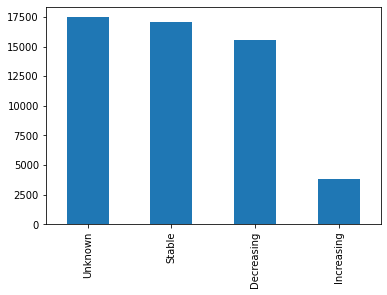

In [12]:
IUCN_cleaned_data.trend.value_counts().plot(kind='bar')

In [16]:
# number of unique species
IUCN_cleaned_data.drop(columns=['country']).drop_duplicates().shape[0]

25211

## Translate classes of animals
From Wikipedia as nothing found on IUCN

mammalia: Mammals

actinopterygii: Ray-finned fishes

insecta: Insects

amphibia: Amphibians

aves: Birds

bivalvia: clams, oysters, cockles, mussels, scallops

gastropoda: Snails and Slugs

cephalaspidomorphi: jawless fishes

clitellata: Worms

reptilia: Reptiles

chondrichthyes: cartilaginous fishes

malacostraca: crustaceans

hydrozoa: individually very small, predatory animals, most living in salt water

turbellaria: flatworms

# Inspect species

In [13]:
# number of animal species in OECD countrys
df.scientific_name.unique().shape[0]

NameError: name 'df' is not defined

In [14]:
species = df.drop(columns=['country']).drop_duplicates()
species.shape

(14992, 6)

In [15]:
species.head()

,class,common_name,scientific_name,trend,region,threat_level
0,Insects,NaN,Erebia mnestra,Stable,"Global, Europe",Least Concern
1,Insects,Marbled Ringlet,Erebia montana,Stable,"Global, Europe",Least Concern
2,Insects,NaN,Erebia tyndarus,Stable,"Global, Europe",Least Concern
3,Insects,NaN,Melitaea asteria,Decreasing,"Global, Europe",Least Concern
4,Insects,NaN,Erebia pronoe,Decreasing,"Global, Europe",Least Concern


<AxesSubplot:xlabel='class'>

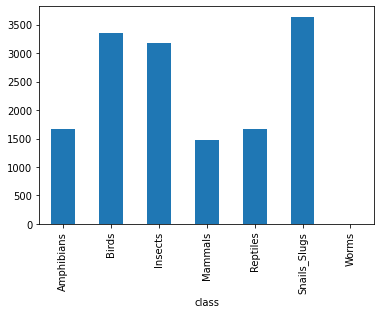

In [16]:
# species per class in OECD countrys
species_per_class = species.groupby('class')['scientific_name'].count()
species_per_class.plot(kind="bar")

# Create data for species per trend per country

In [17]:
# transform data
grouped = df.groupby(['country', 'trend'])['scientific_name'].count().reset_index(name='count')
species_trend_country = grouped.pivot(index='country', columns='trend', values='count')
species_trend_country = species_trend_country.fillna(0.0)
species_trend_country.shape

(48, 4)

In [18]:
species_trend_country.head()

trend,Decreasing,Increasing,Stable,Unknown
country,,,,
Argentina,20.0,2.0,7.0,13.0
Armenia,185.0,70.0,164.0,108.0
Australia,9.0,1.0,4.0,13.0
Austria,299.0,87.0,337.0,282.0
Azerbaijan,209.0,75.0,193.0,143.0


In [19]:
species_trend_country.sum()

trend
Decreasing     9832.0
Increasing     2773.0
Stable        11813.0
Unknown       10941.0
dtype: float64

## Create data for species per threat level per country

In [20]:
# check for missing values
df.isna().sum()

class                  0
common_name        11553
scientific_name        0
trend                  0
region                 0
threat_level           0
country                0
dtype: int64

In [21]:
# transform data
grouped = df.groupby(['country', 'threat_level'])['scientific_name'].count().reset_index(name='count')
species_tl_country = grouped.pivot(index='country', columns='threat_level', values='count')
species_tl_country = species_tl_country.fillna(0.0)

In [22]:
species_tl_country.head()

threat_level,Critically Endangered,Data Deficient,Endangered,Extinct,Extinct in the Wild,Least Concern,Near Threatened,Vulnerable
country,,,,,,,,
Argentina,1.0,0.0,2.0,0.0,0.0,26.0,7.0,6.0
Armenia,6.0,17.0,6.0,0.0,0.0,438.0,37.0,23.0
Australia,4.0,0.0,1.0,0.0,0.0,17.0,1.0,4.0
Austria,21.0,62.0,24.0,1.0,0.0,776.0,80.0,41.0
Azerbaijan,5.0,32.0,6.0,0.0,0.0,511.0,39.0,27.0


This DataFrames include the same data as the "Table 6a" and makes not that much sense to use but we could use this to check if the data on the webpage is reasonable or if ther has gone something wrong when web scraping.

## Create data for species per class per country

In [23]:
# transform data
grouped = df.groupby(['country', 'class'])['scientific_name'].count().reset_index(name='count')
species_class_country = grouped.pivot(index='country', columns='class', values='count')
species_class_country = species_class_country.fillna(0.0)

In [24]:
species_class_country.head()

class,Amphibians,Birds,Insects,Mammals,Reptiles,Snails_Slugs,Worms
country,,,,,,,
Argentina,3.0,14.0,3.0,20.0,2.0,0.0,0.0
Armenia,8.0,297.0,73.0,92.0,43.0,14.0,0.0
Australia,5.0,0.0,1.0,6.0,2.0,13.0,0.0
Austria,19.0,305.0,323.0,88.0,13.0,256.0,1.0
Azerbaijan,11.0,348.0,73.0,104.0,50.0,34.0,0.0


This DataFrames include the same data as the "Table 5" and makes not that much sense to use but we could use this to check if the data on the webpage is reasonable or if ther has gone something wrong when web scraping.